In [1]:
import numpy as np
import matplotlib.pyplot as plt

(100, 100)
[0.38340524 0.5        0.61204713 0.70951971 0.78781038 0.84715959
 0.89047493 0.92139785 0.94324405 0.95864044 0.96952302 0.97726429
 0.98281816 0.98684202 0.9897882  0.99196884 0.99360056 0.99483479
 0.99577824 0.99650684 0.99707507 0.9975224  0.99787772 0.99816231
 0.99839205 0.99857887 0.99873178 0.9988577  0.99896193 0.99904861
 0.99912096 0.99918153 0.99923233 0.99927498 0.99931078 0.99934078
 0.99936585 0.99938671 0.99940394 0.99941804 0.99942944 0.99943852
 0.99944559 0.99945095 0.99945485 0.99945755 0.99945927 0.99946024
 0.99946068 0.99946079 0.9994608  0.99946092 0.99946135 0.99946232
 0.99946403 0.99946668 0.99947047 0.99947559 0.99948219 0.99949043
 0.99950042 0.99951224 0.99952594 0.99954153 0.99955897 0.99957818
 0.99959901 0.9996213  0.99964481 0.9996693  0.99969446 0.99971999
 0.99974556 0.99977085 0.99979553 0.99981931 0.99984194 0.99986317
 0.99988283 0.99990079 0.99991698 0.99993135 0.99994395 0.99995481
 0.99996405 0.99997179 0.99997817 0.99998335 0.9999

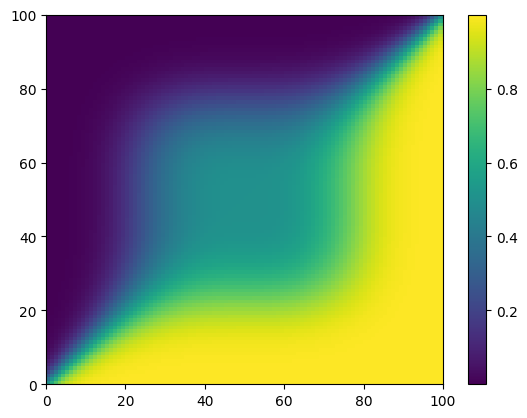

In [2]:
# make some random game model:

P = 100
L = 1

def sigmoid(x):
    return 1 / (1+ np.exp(-x))

def softmax(x):
    x_max = x.max(axis=-1, keepdims=True)
    return np.exp(x - x_max) / np.exp(x - x_max).sum(-1, keepdims=True)

def relu(x):
    return x * (x >0)

latents = np.random.randn(P,L)
order = np.argsort(latents[:,0])
latents = latents[order]
W = np.random.randn(L,L)
B = np.random.randn(L)
logits = 0.5 * np.einsum("pi,ij,sj->ps", latents, W, latents) + np.einsum("pi,i -> p", latents, B)
#logits = logits + logits.T

s = (np.linspace(-1, 1, P) * 2) ** 3
logits = (s[None,:] - s[:,None])
print(logits.shape)
probs = sigmoid(logits)
probs = (probs - probs.T + 1)/ 2
print(probs[1,:])

fig, ax = plt.subplots(1)
M = ax.pcolor(probs)
fig.colorbar(M, ax=ax)


perm = np.random.permutation(P)
inv_perm = np.argsort(perm)

In [3]:
def remove(array, i):
    arr = np.concatenate([array[:i], array[i+1:]])
    return arr

def final_err_score(final_elo, lim=None):
    if lim is not None:
        final_elo = final_elo[:lim]
    P = len(final_elo)
    err = np.mean(np.abs(np.argsort(-final_elo) - np.arange(P))**2)
    return err

def match_fun(i,j):
    score = (probs[perm[i],perm[j]] > np.random.rand(3)).mean()
    return score

def zero_state(K):
    return (1200 * np.ones(K), 1200 * np.ones(K), 300**2 * np.ones(K), np.zeros(K))


def update_elo(state, math_fun, n=1, alpha=1e-4, beta=1e-4, K=3, mom1=0.0,mom2 = 0.93, d0=400, update_factor=0.1):

    (elo, elo_mom, D_elo, counts) = state
    S = len(elo)

    for k in range(n):

        if alpha <= 0 or S == 1:
            i = np.random.choice(S)
        else:
            #p_i = softmax(- 0 * np.log2( 1 + counts))
            p_i = softmax(alpha * D_elo * K) \
                  #* softmax(30 * (elo_mom >1300)) # bonus for top scores

            p_i /= np.sum(p_i)
            i = np.random.choice(p=p_i, a=np.arange(S))

        if beta  <= 0 or S == 1:
            j = np.random.choice(S)
        else:
            # smallest distance to
            #d_elo_i = max(1,np.std(elo_mom))
            d_elo_i = np.sqrt(D_elo[i])
            p_j = - beta * (np.abs(elo_mom[i] - elo_mom)/ d_elo_i * K) ** 2 # TODO: This K should be removed and take only beta.
            p_j[i] -= 10_000_000 # avoid recalling i==j
            p_j = softmax(p_j)
            p_j /= p_j.sum()

            j = np.random.choice(p=p_j, a=np.arange(S))
        
        if i == j:
            continue

        update_j = True if update_factor is None else D_elo[j] > D_elo[i] * update_factor

        score = math_fun(i,j)
         #(probs[i,j] > np.random.rand() + probs[j,i] > np.random.rand()) / 2
        #score = (probs[i,j] > np.random.rand() + probs[j,i] < np.random.rand()) / 2

        e_i = 1 / (1 + np.power(10, (elo[j] - elo[i])/d0)) # sigmoid( log10 * (elo[j] - elo[i]) / d0)
        e_j = 1 / (1 + np.power(10, (elo[i] - elo[j])/d0))

        de_i = K * (score - e_i)
        de_j = K * ((1-score) - e_j)

        counts[i] +=1
        if update_j: counts[j] += 1

        elo[i] += de_i
        if update_j: elo[j] += de_j

        elo_mom[i] = mom1 * elo_mom[i] + (1-mom1) * elo[i]
        if update_j: elo_mom[j] = mom1 * elo_mom[j] + (1-mom1) * elo[j]

        D_elo[i] = D_elo[i] * mom2 + (1-mom2) * (elo[i] - elo_mom[i])**2 # reduced to de_i if mom1 is 0
        if update_j: D_elo[j] = D_elo[j] * mom2 + (1-mom2) * (elo[j] - elo_mom[j])**2


    return state


error: toperr=29.40 	 err=154.44 	 val=0
error: toperr=8.60 	 err=80.60 	 val=1.0
error: toperr=5.70 	 err=95.98 	 val=10.0
error: toperr=6.40 	 err=92.02 	 val=100.0
error: toperr=4.30 	 err=112.24 	 val=1000.0


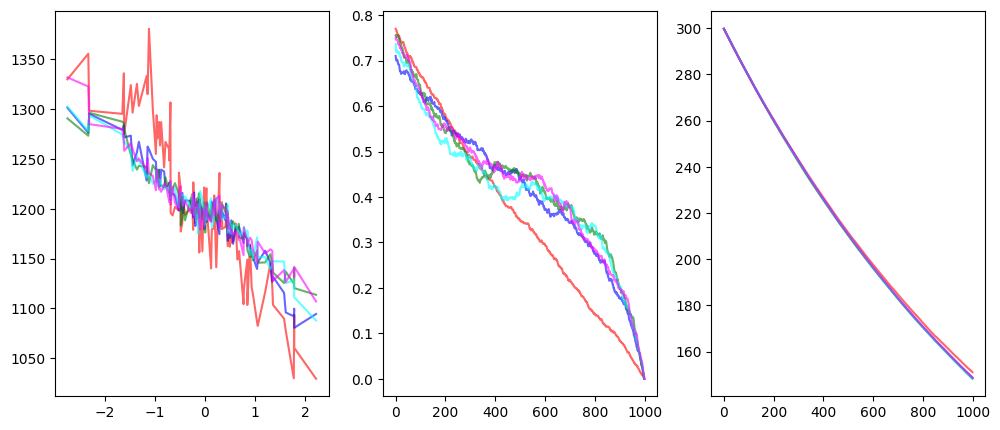

In [4]:
def eval_sync(n, **kwargs):

    state = zero_state(P)


    elo_list = []
    d_elos = []
    for _ in range(n):
        update_elo(state, match_fun, n=1, **kwargs)
        elo, elo_mom, D_elo, *_ = state
        d_elos.append(np.mean(np.sqrt(D_elo)))
        elo_list.append(np.copy(elo))

    std0 = np.std(elo_list[-1])
    elo_conv = [np.mean(np.abs(e - elo_list[-1][:len(e)]) / std0) for e in elo_list]

    return elo_mom, elo_conv, d_elos



#values = [1,3,10]
values = [0,1e-0,1e1,1e2,1e3,1e4]
#values = [0.5, 1, 2]
colors = ["red", "blue", "green", "cyan", "magenta"]

fig, ax_list = plt.subplots(1,3, figsize=(12,5))
for val, color in zip(values, colors):
    final_elo, elo_conv, d_elos = eval_sync(1000, alpha=0, beta=val, K=30, mom1=0.9, mom2=0.93,d0=400)
    final_elo = final_elo[inv_perm]
    top_err = final_err_score(final_elo, 20)
    err = final_err_score(final_elo)
    print(f"error: toperr={top_err:0.02f} \t err={err:0.02f} \t val={val}")

    p0 = latents
    ax_list[0].plot(p0, final_elo, color=color, alpha=0.6)
    ax_list[1].plot(elo_conv, color=color, alpha=0.6)
    ax_list[2].plot(d_elos, color=color, alpha=0.6)

error: toperr=42.10 	 err=230.80 	 val=1e-06
error: toperr=35.80 	 err=188.74 	 val=1.0
error: toperr=48.00 	 err=194.50 	 val=100.0
error: toperr=31.50 	 err=193.94 	 val=10000.0
error: toperr=31.80 	 err=191.82 	 val=1000000.0


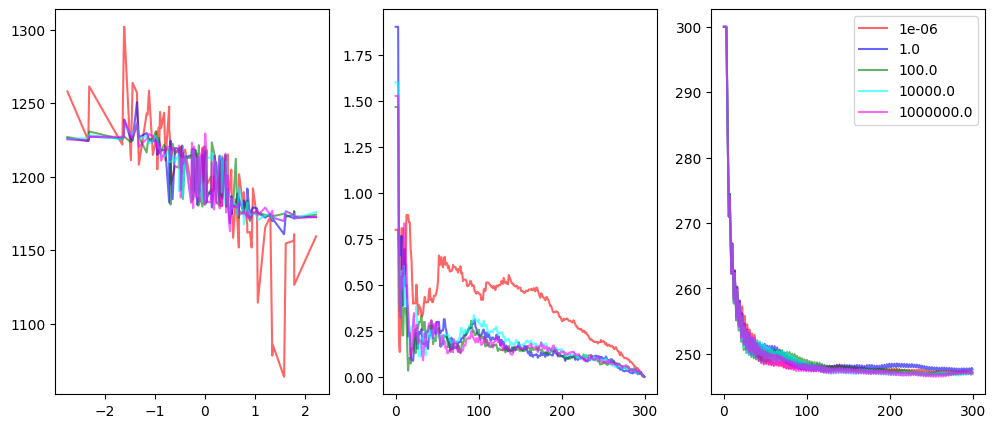

In [9]:
def eval_async(n, **kwargs):

    state = zero_state(1)

    d_elos = []
    elo_list = []
    for i in range(n):
        if len(state[0]) < P and i > len(state[0]) * n // P:
            new_state = zero_state(1)
            state = tuple([np.concatenate([s1,s2]) for s1, s2 in zip(state, new_state)])
            #print(f"added state at {i}: {perm[len(state[0])-1]}/{len(state[0])}")
        update_elo(state, match_fun, n=1, **kwargs)
        elo, elo_mom, D_elo, *_ = state

        d_elos.append(np.mean(np.sqrt(D_elo)))
        elo_list.append(np.copy(elo))

    std0 = np.std(elo_list[-1])
    elo_conv = [np.mean(np.abs(e - elo_list[-1][:len(e)]) / std0) for e in elo_list]

    return elo_mom, elo_conv, d_elos



values = [1e-6, 1e0, 1e2, 1e4, 1e6]


fig, ax_list = plt.subplots(1,3, figsize=(12,5))
for val, color in zip(values, colors):
    final_elo, elo_conv, d_elos = eval_async(300, alpha=val, beta=1, K=100, mom1=0.9, mom2=0.93,d0=400, update_factor=None) #.01)
    final_elo = final_elo[inv_perm]

    top_err = final_err_score(final_elo, 20)
    err = final_err_score(final_elo)
    print(f"error: toperr={top_err:0.02f} \t err={err:0.02f} \t val={val}")

    p0 = latents
    ax_list[0].plot(p0, final_elo, color=color, alpha=0.6, label=f"{val}")
    ax_list[1].plot(elo_conv, color=color, alpha=0.6, label=f"{val}")
    ax_list[2].plot(d_elos, color=color, alpha=0.6, label=f"{val}")

plt.legend()